# 🤖 Prédiction de retours boursiers (ML)

## Objectif
- Prédire si le prix va monter ou descendre demain.
- Utiliser des features techniques
- Modèles : Random Forest, Réseau de neuronnes (RNN)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

LIMITE_FILES = 10

sources = os.listdir("../1-data-collection/csv/")
sources = [source for source in sources if source.endswith('.csv')][:LIMITE_FILES]
for source in sources:
    data = pd.read_csv(f"../1-data-collection/csv/{source}", index_col=0, parse_dates=True)

    data['return_1d'] = data['Close'].pct_change()
    data['MA10'] = data['Close'].rolling(10).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data = data.dropna()

    X = data[['return_1d', 'MA10', 'MA50']]
    y = data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.48      0.72      0.58       218
           1       0.64      0.40      0.49       276

    accuracy                           0.54       494
   macro avg       0.56      0.56      0.53       494
weighted avg       0.57      0.54      0.53       494

              precision    recall  f1-score   support

           0       0.49      0.65      0.56       235
           1       0.55      0.39      0.45       259

    accuracy                           0.51       494
   macro avg       0.52      0.52      0.50       494
weighted avg       0.52      0.51      0.50       494

              precision    recall  f1-score   support

           0       0.52      0.39      0.45        94
           1       0.54      0.66      0.59       100

    accuracy                           0.53       194
   macro avg       0.53      0.53      0.52       194
weighted avg       0.53      0.53      0.52       194

              preci

## Application d'un RNN

Première approche : 
- En entrée on a le jour $x_n$ et en sortie le jour $x_{n+1}$
- Objectif :
    - prédire le jour suivant à l'aide du jour précédent
- Hypothèses de problemes en amont :
    - un jour peut ne pas être suffisant pour prédire l'évolution du marché au jour $x_{n + 1}$

Deuxième approche :
- Ajouter une technique d'analyse de sentiment (lstm) sur l'actualité (-1 Négatif max / +1 positif max)
- Objetif :
    - La bourse dépends de l'actualité également donc celà ne sera que bénéfique pour le modèle
- Hypothèses de problèmes en amont :
    - Récupérer les actus sur le long terme est compliqué
    - Devoir faire matcher différents site de news car certains peuvent être biaisé ou se trompent
    - ATTENTION AUX NEWS PROPRIETAIRE ET VERIFIER A QUI ELLE APPARTIENT

Open         2.784750e+01
High         2.786000e+01
Low          2.683750e+01
Close        2.733250e+01
Adj Close    2.428858e+01
Volume       2.128184e+08
Name: 2015-01-02 00:00:00, dtype: float64
X: 2514, y: 2514
X_scaled: (2514, 6)
y_scaled: (2514, 6)
Epoch [10/100], Loss: 0.4968
Epoch [20/100], Loss: 0.3458
Epoch [30/100], Loss: 0.2389
Epoch [40/100], Loss: 0.1708
Epoch [50/100], Loss: 0.1307
Epoch [60/100], Loss: 0.1083
Epoch [70/100], Loss: 0.0961
Epoch [80/100], Loss: 0.0888
Epoch [90/100], Loss: 0.0841
Epoch [100/100], Loss: 0.0813
Test Loss: 0.0359
Predictions: (503, 6)


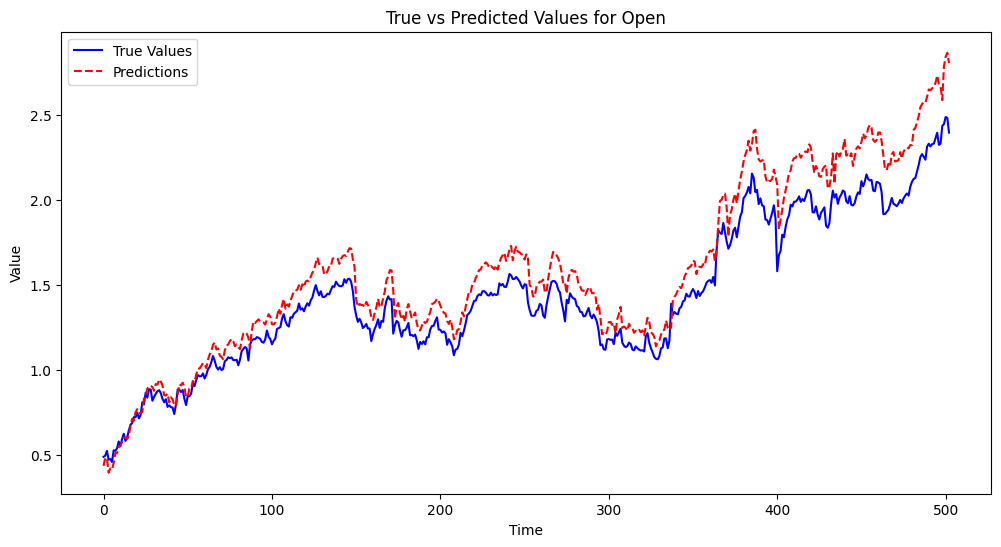

Accuracy for dimension 0: 1.00
RMSE for dimension 0: 0.0631


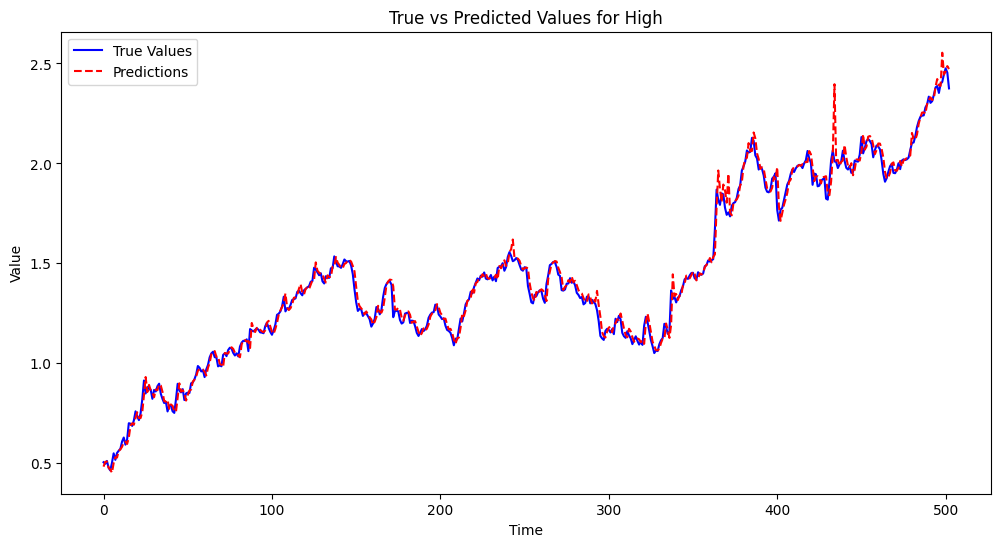

Accuracy for dimension 1: 0.99
RMSE for dimension 1: 0.0772


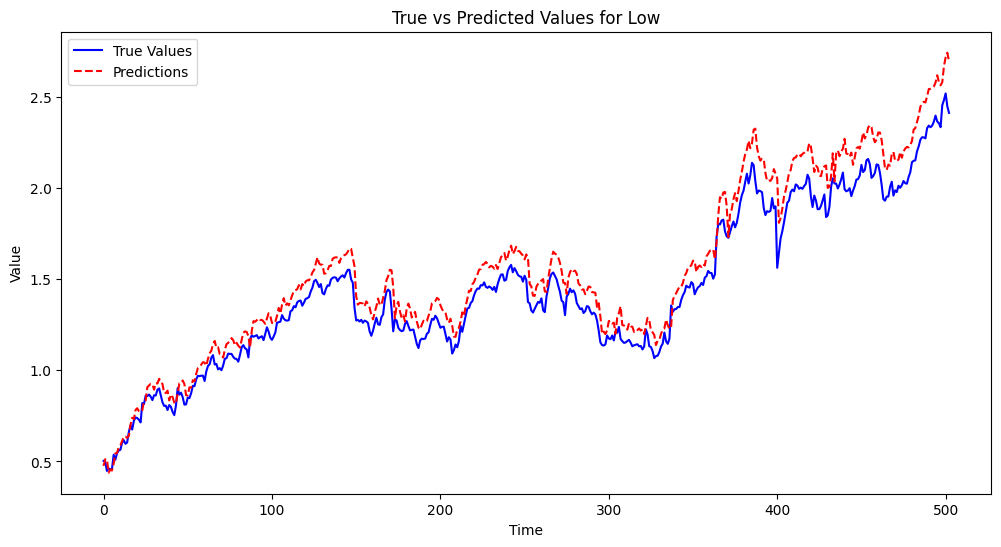

Accuracy for dimension 2: 0.99
RMSE for dimension 2: 0.0892


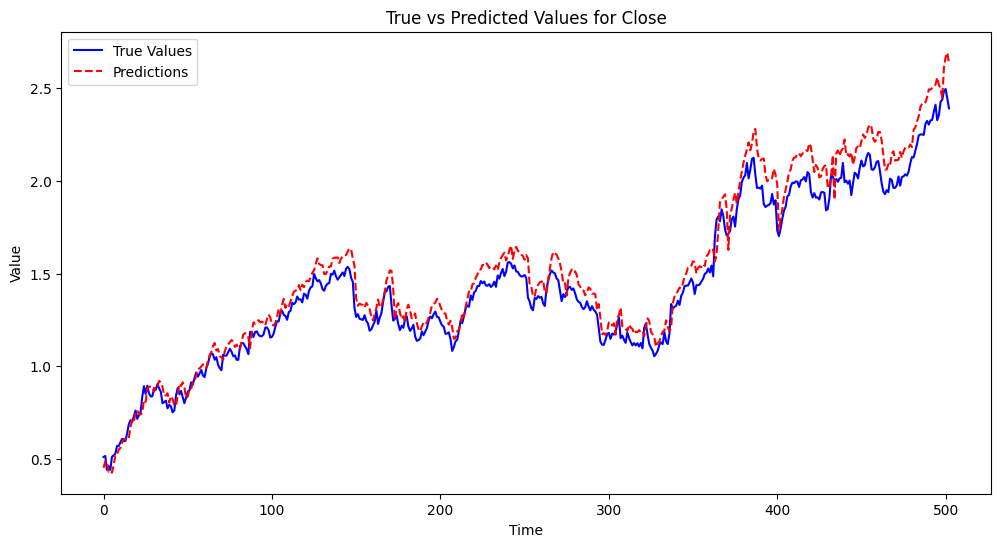

Accuracy for dimension 3: 0.99
RMSE for dimension 3: 0.0892


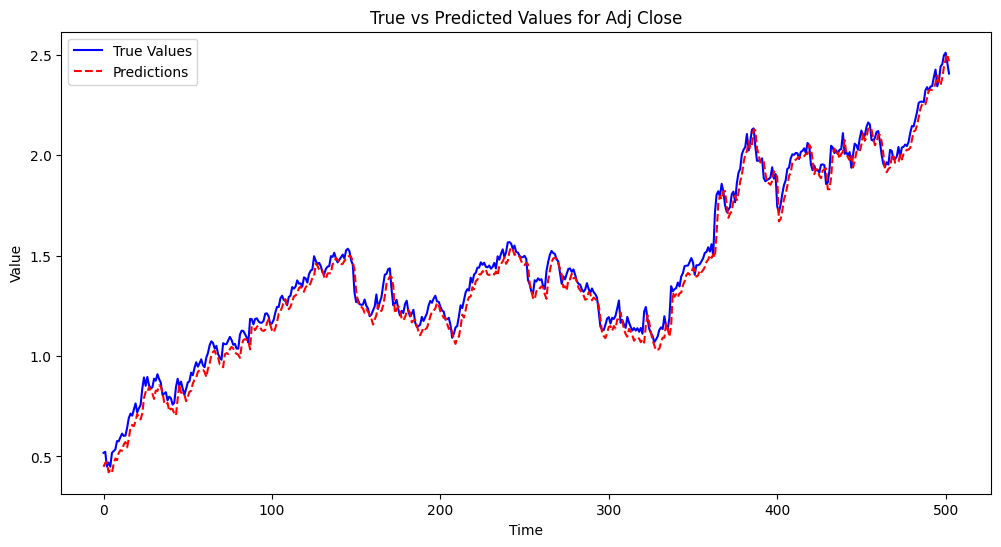

Accuracy for dimension 4: 0.99
RMSE for dimension 4: 0.1092


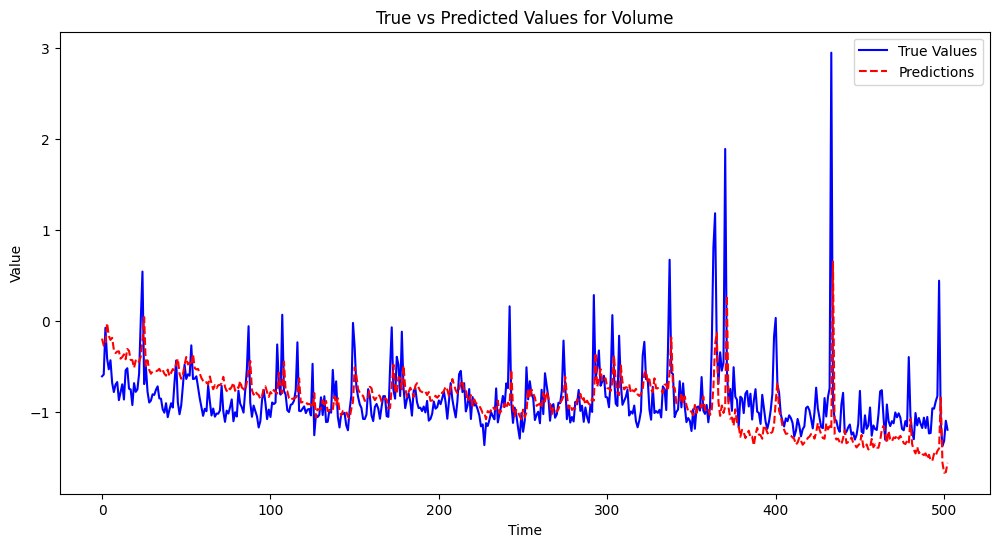

Accuracy for dimension 5: 0.99
RMSE for dimension 5: 0.1180
Global Accuracy: 0.99


In [30]:
# Première apporche RNN x_n -> x_n+1

data = pd.read_csv(f"../1-data-collection/csv/{sources[0]}", index_col=0, parse_dates=True)

print(data.iloc[0])  # Affiche la première ligne

def prepare_data(data: pd.DataFrame):
    return [(data.iloc[i], data.iloc[i + 1]) for i in range(len(data) - 1)]

X, y = zip(*prepare_data(data))
print(f"X: {len(X)}, y: {len(y)}")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"X_scaled: {X_scaled.shape}") # (2514, 6)
y_scaled = scaler.fit_transform(y)
print(f"y_scaled: {y_scaled.shape}") # (2514, 6)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, shuffle=False, test_size=0.2)

import torch
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
input_size = X_train.shape[1]
hidden_size = 64
output_size = y_train.shape[1]
model = MLP(input_size, hidden_size, output_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def train(model, X_train, y_train, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
train(model, X_train, y_train, criterion, optimizer, epochs=100)
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        targets = torch.tensor(y_test, dtype=torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(f"Test Loss: {loss.item():.4f}")
evaluate(model, X_test, y_test)
def predict(model, X):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs)
        return outputs.numpy()
predictions = predict(model, X_test)
print(f"Predictions: {predictions.shape}")  # (502, 6)

import matplotlib.pyplot as plt
def plot_predictions(y_true, y_pred, dim, name_dim='Dimension'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, dim], label='True Values', color='blue')
    plt.plot(y_pred[:, dim], label='Predictions', color='red', linestyle='--')
    plt.title('True vs Predicted Values for {}'.format(name_dim))
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
for dim in range(y_test.shape[1]):
    plot_predictions(y_test, predictions, dim, name_dim=data.columns[dim])
    # Accuracy
    predictions[:, dim] = (predictions[:, dim] > 0.5).astype(int)
    y_test[:, dim] = (y_test[:, dim] > 0.5).astype(int)
    accuracy = (predictions[:, dim] == y_test[:, dim]).mean()
    print(f"Accuracy for dimension {dim}: {accuracy:.2f}")
    # RMSE
    rmse = ((predictions[:, dim] - y_test[:, dim]) ** 2).mean() ** 0.5
    print(f"RMSE for dimension {dim}: {rmse:.4f}")

# Accuracy globale
accuracy_global = (predictions == y_test).mean()
print(f"Global Accuracy: {accuracy_global:.2f}")